# Peer graded assignment

## Capstone Project: Battle of the neighbourhoods

## Introduction


### Description of the problem and background

The population of New York City has grown considerably over the last decades. New York is very diverse. It consist of a large and ethnically diverse group of people. New York City is home to over 18 million people. With it's diverse culture, comes diverse way of living for the people of New York. Notably, the differents kinds of lifestyles, music genres, dressing, movies, foods, languages, etc.

There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc. The idea of this project is to help my client who is planning to open an Italian restaurant in New York chose the right location by providing data about the different types restaurant already existing in each neighborhood as well as the competitors already present in the same regions. Since the New York demography is so big, my client needs deeper insight from available data in other to decide where best to establish the restaurant in order to receive the maximum clientele. So as part of this project , we will list and visualize all major parts of New York City that has great Italian resturants. I will also compare neighborhoods where customer gives the best tips and ratings about  Italian restaurant.

## Data

### Data Sources

New York City data  contains many of list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset. It was obtained from the from the Applied Data science Capstone course for ibm.
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city and available Chinese resturants in each of the neighborhoods.

Data source : Fousquare API Description.
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Chinese resturants.

GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm 
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.



### Sample queries that can be answered by the data

1. What is best location in New York City for Chinese Cuisine?
2. Which areas have already existing Chinese Resturant Market?
3. Which areas lack Chinese Resturants?
4. Which is the best place to site a Chinese restaurant?




### Steps that will be used to solve the problem

1. Collect the new york city data from https://cocl.us/new_york_dataset
2. Using FourSquare API we will find all venues for each neighborhood.
3. Filter out all venues that are Italian Resturants.
4. Find rating , tips and like count for each Italian Resturants using FourSquare API.
5. Using rating for each resturant , we will sort that data.
6. Visualize the Ranking of neighborhoods using folium library


## Analysis

In [2]:
!pip install beautifulsoup4
!pip install geocoder
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 112kB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 102kB 4.4MB/s ta 0:00:01
     |████████████████████████████████| 92kB 4.5MB/s eta 0:00:011
     |████████████████████████████████| 829kB 15.9MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Libraries imported.


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [30]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '******************************' # changed my Foursquare ID
    CLIENT_SECRET = '******************************' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [31]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '******************************' # i have changed the id with ##
    CLIENT_SECRET = '*****************************' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [12]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [13]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [14]:
df = new_york_data.iloc[45:60,:]
df

,Borough,Neighborhood,Latitude,Longitude
45,Bronx,Edenwald,40.884561,-73.848083
46,Brooklyn,Bay Ridge,40.625801,-74.030621
47,Brooklyn,Bensonhurst,40.611009,-73.995180
48,Brooklyn,Sunset Park,40.645103,-74.010316
49,Brooklyn,Greenpoint,40.730201,-73.954241
50,Brooklyn,Gravesend,40.595260,-73.973471
51,Brooklyn,Brighton Beach,40.576825,-73.965094
52,Brooklyn,Sheepshead Bay,40.586890,-73.943186
53,Brooklyn,Manhattan Terrace,40.614433,-73.957438
54,Brooklyn,Flatbush,40.636326,-73.958401


In [33]:
new_york_data.shape

(306, 4)

In [25]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:1
done
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:1
done
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:2
done
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Italian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Italian Resturants in Baychester, Bronx:2
done
( 12 / 306 ) Italian Resturants in Pelham Parkway, Bronx:3
done
( 13 / 306 ) Italian Resturants in City Island, Bronx:3
done
( 14 / 306 ) Italian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Italian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Italian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Italian R

KeyError: 'groups'

In [34]:
#creating multiple intances
#a = italian_rest_ny
#a.shape
b = italian_rest_ny
b.shape

(457, 4)

### We have a total of 457 italian restaurant across New York

In [35]:
italian_rest = a
italian_rest

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's
5,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden
6,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
7,Bronx,Pelham Parkway,4b10591af964a5205f6e23e3,Patricia's
8,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
9,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood


In [38]:
italian_rest.groupby('Borough')['ID'].count()

Borough
Bronx             78
Brooklyn         103
Manhattan        103
Queens            85
Staten Island     88
Name: ID, dtype: int64

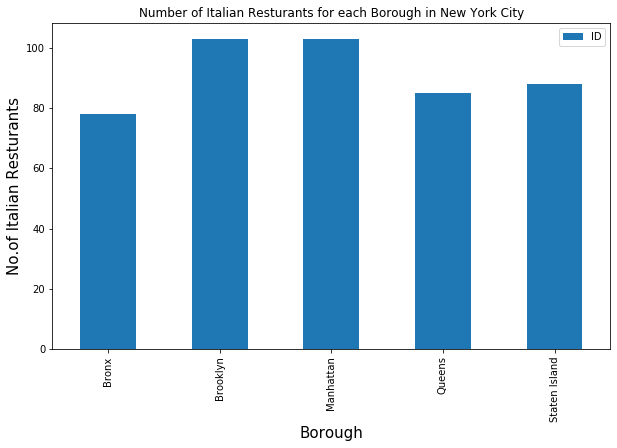

In [36]:
plt.figure(figsize=(10,6))
# title
plt.title('Number of Italian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


### We can see that according to our data, both the Brooklyn and Manhattan has the same number of italian restaurants

In [43]:
italian_rest['Neighborhood'].describe()

count         457
unique        152
top       Belmont
freq           14
Name: Neighborhood, dtype: object

### There are 152 unique different neighbourhoods where one can find an italian restaurant with the majority of them in Belmont

### We can get the ratings and tips of italian restaurant in each neighborhood but due to the limited number of API calls we can run, we will only the italian restaurants in belmont and site our restaurant over there

In [47]:
belmont = italian_rest[italian_rest['Neighborhood']=='Belmont']
belmont

,Borough,Neighborhood,ID,Name
44,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
45,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
46,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
47,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
48,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
49,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's
50,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
51,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
52,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
53,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant


In [49]:
#Now we will get the ratings of each restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.3     4
( 1 / 457 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.3     4
( 2 / 457 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.3    14
( 3 / 457 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.8     8
( 4 / 457 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.5     6
( 5 / 457 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.4     8
( 6 / 457 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96a

KeyError: 'venue'

## Due to limited number of API calls, we can only get rating for 50 restaurants

In [50]:
italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.3,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.8,8
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.5,6


In [51]:
italian_rest_stats_ny.to_csv('ratings_records.csv')

In [52]:
italian_rest_stats_ny.describe()

,Rating
count,50.000000
mean,7.596000
std,1.372613
min,0.000000
25%,6.925000
50%,7.900000
75%,8.500000
max,9.000000


In [54]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


#### In order for proper analysis, i am changing the data types for the Likes and Tips columns to float

In [56]:
italian_rest_stats_ny['Likes'] = italian_rest_stats_ny['Likes'].astype('float')
italian_rest_stats_ny['Tips'] = italian_rest_stats_ny['Tips'].astype('float')

In [62]:

italian_rest_stats_ny[italian_rest_stats_ny['Likes']==max(italian_rest_stats_ny['Likes'])]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
37,Bronx,Van Nest,3fd66200f964a5207bf11ee3,F & J Pine Tavern,176.0,8.8,72.0


F & J Tavern in Van Nest at the bronx is the italian restaurant with the maxium number of likes

In [63]:

italian_rest_stats_ny[italian_rest_stats_ny['Tips']==max(italian_rest_stats_ny['Tips'])]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
37,Bronx,Van Nest,3fd66200f964a5207bf11ee3,F & J Pine Tavern,176.0,8.8,72.0


F & J tavern also has the most tips aswell

In [65]:
italian_rest_stats_ny[italian_rest_stats_ny['Rating']==max(italian_rest_stats_ny['Rating'])]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
12,Bronx,Fordham,4acf80aef964a52025d420e3,Tino's Delicatessen,145.0,9.0,48.0
44,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen,145.0,9.0,48.0


The max ratings are two restaurants in the bronx that belongs to the same person(s) call Tino's Delicatessen

#### Grouping them according to neighbourhood in order to identify which neighbourhood has the maximum tips and ratings

In [70]:
neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(15)

,Neighborhood,Average Rating
1,Belmont,8.600000
13,Van Nest,8.400000
4,Fordham,8.050000
0,Baychester,7.950000
8,Morrisania,7.900000
10,Pelham Parkway,7.900000
7,Morris Park,7.740000
15,Woodlawn,7.550000
2,City Island,7.466667
6,Melrose,7.400000


the output shows that the best ratings are for italian restaurants in Belmont and Van Nest area

#### I am coming to use folium map to show the locations of italian restaurant with maximum retings

In [72]:
neighborhood_stats_map = neighborhood_stats[neighborhood_stats['Average Rating']>=8.0]
neighborhood_stats_map

,Neighborhood,Average Rating
1,Belmont,8.60
4,Fordham,8.05
13,Van Nest,8.40


In [74]:
neighborhood_stats_map = pd.merge(neighborhood_stats_map,new_york_data,on='Neighborhood')
neighborhood_stats_map

,Neighborhood,Average Rating,Borough_x,Latitude_x,Longitude_x,Borough_y,Latitude_y,Longitude_y
0,Belmont,8.60,Bronx,40.857277,-73.888452,Bronx,40.857277,-73.888452
1,Fordham,8.05,Bronx,40.860997,-73.896427,Bronx,40.860997,-73.896427
2,Van Nest,8.40,Bronx,40.843608,-73.866299,Bronx,40.843608,-73.866299


In [95]:
rest_map = folium.Map(location=geo_location('New York'),zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in neighborhood_stats_map[['Latitude_x','Longitude_y']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
neighborhood_stats_map['Label']=neighborhood_stats_map['Neighborhood']+', '+neighborhood_stats_map['Borough_x']+'('+neighborhood_stats_map['Average Rating'].map(str)+')'


for lat, lng, label in neighborhood_stats_map[['Latitude_x','Longitude_y','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(rest_map)        
# add incidents to map
rest_map.add_child(incidents)

## Conclusions

1. The bronx contains venue for some of the best italian dishes in newyork
2. Brooklyn and Manhattan have potential Italian Resturant Market
4. The bronx is the best place to stay if you prefer Italian Cuisine.
6. The ranking is purely on basis of rating of resturants
7. The accuracy of data depends purely depends on the data provided by FourSquare



### NB: Due to insufficient API calls, the steps outlined in this project may not be accurate but nonetheless it laids down a procedure that can be used to solve the problem

In [101]:
print('Michael sekyere')

Michael sekyere
